# Gas transport model for CH<sub>4</sub> transport in a tree

This notebook shows how the gas transport model localted in folder [transport_model](transport_model) can be run to solve CH<sub>4</sub> transport in a tree. The input parameters used here are not complitely realistic but hopefully demonstrates what the model needs in order to run.

# How to run this notebook

This notebook is written using Jupyter notebooks and Python (version 3.9.16 but also newer versions should work). You can go through the notebook and look at the figures produced from the gas transport model output without doing anything by simply opening the .html version of the notebook on your browser. If you would like to run the notebook and edit input parameters you need to:

1. Install python (at least version 3.9.16) from [getpython.org](https://getpython.org) and pip. You can follow for example these instructions on windows [linuxhint](https://linuxhint.com/activate-virtualenv-windows/). For other operating systems you can search instructions for example with "install python and pip [your operating system]" and "create python virtual environment [your operating system]"

2. Create a virtual environment using terminal or command prompt
```console
>> python -m venv ch4venv
```

- You can read more about virtual environments and what they are from [here](https://realpython.com/python-virtual-environments-a-primer/)

3. Activate the virtual environment using terminal or command prompt
```console
>> source ch4venv/bin/activate
```

4. Install the required python packages using terminal or command prompt
```console
(ch4venv) >> pip install -r requirements.txt
```

5. Start jupyter notebook server using terminal or command prompt
```console
(ch4venv) >> jupyter-notebook
```
- A web browser should open which should show the contents of this directory. Click the file "ch4_transport_example.ipynb"
    - If a browser window does not open copy the link given in the terminal and navigate to it using your browser
- You can run cells by clicking "Run cell" from the top toolbar or by pressing "ctrl + enter"

6. (optional) You can modify input values and then run the model again. To run the model again with your modifications
    - Either remove file "ch4_transport_test_out.nc" or rename the variable called 'outputfile'
    - Run the whole notebook again from top menu Cell->Run all

In [12]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

from transport_model.gas import Gas

sns.set_context('notebook')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model input

## Table of all the model input and output parameters

These parameters are set below

| Input parameter                                                 | Unit                                    | Notes                                                  |
|-----------------------------------------------------------------|-----------------------------------------|--------------------------------------------------------|
| Tree height                                                     | m                                       |                                                        |
| Tree radius                                                     | m                                       |                                                        |
| Axial resolution                                                | m                                       | Can be tested to find a good value                     |
| Radial resolution                                               | m                                       | Can be tested to find a good value                     |
| Simulation time                                                 | s                                       |                                                        |
| Henry's law coefficient for CH<sub>4</sub>                      | m<sup>3</sup> air / m<sup>3</sup> water | From the literature                                    |
| Initial CH<sub>4</sub> concentration                            | mol/m<sup>3</sup>                       | Can be approximated and run the model for a "burn in" period to allow the system to reach equilibrium|
| Sapflow velocity                                                | m/s                                     |                                                        |
| Xylem to heartwood ratio                                        | -                                       | by area or by length|
| Radial diffusion coefficient of CH<sub>4</sub> in the tree      | m<sup>2</sup>/s                         |                                                        |
| Axial diffusion coefficient of CH<sub>4</sub> in the tree       | m<sup>2</sup>/s                         |                                                        |
| equilibration rate between gas and aqueous phase CH<sub>4</sub> | 1/s                                     | Can be set to high value for instantenous equilibrium? |
| Volume fraction of air in the tree                              | -                                       |                                                        |
| Volume fraction of water in the tree                            | -                                       |                                                        |
| Volume fraction of cell in the tree                             | -                                       |                                                        |
| Uptake rate of water from the roots                             | m<sup>3</sup>/s                         | If CH<sub>4</sub> transport from soil through root water uptake is modelled|
| CH<sub>4</sub> concentration in the soil                        | mol/m<sup>3</sup>                       | If CH<sub>4</sub> transport from soil through root water uptake is modelled|
| Strengths of other source and sink processes                    | mol/s                                   | If other sources are modelled                          |
| Ambient gas phase concentration of CH<sub>4</sub>               | mol/m<sup>3</sup>                       | Also in the soil                                       |
| Name of the output file                                         | -                                       |                                                        |
| Max lines per time step                                         | -                                       | Currently, this is suggested to be set as 1 and control the time step manually e.g., in this notebook we set the time step to one hour but could use 5 mins as well. The model has it's own intrinsic (dynamic) time step which it uses to run the model manually specified time step at a time |



## Tree dimensions

First we need to define how many axial and radial elements the model has and what is the length and height of each element.

We'll model a tree whose height is 10 m and radius 5 cm and whose roots reach depth of 0.5 meters. The model will have 105 axial elements and 10 radial elements corresponding to axial resolution of 10 cm and radial resolution of 0.5 cm

In [13]:
na = 105 # number axial element
nr = 10 # number of radial elements

tree_height = 10 # tree height (m)
rooting_depth = 0.5 # rooting depth (m)
tree_radius = 0.05 # tree radius (m)

element_heights = np.repeat([(tree_height+rooting_depth)/na], repeats=na*nr).reshape(na,nr)

element_radius = np.repeat([tree_radius/nr], repeats=na*nr).reshape(na,nr)

## Simulation time

Next we need to set the simulation time. We'll simulate the transport of CH<sub>4</sub> for two weeks with 1 hour time interval. The 1h time interval will be used to update the sapflow velocity and root water uptake rates.

In [14]:
simulation_time = np.linspace(0,14*24*60*60, 14*24+1) # simulation time in seconds

## Initial CH<sub>4</sub> concentration

Next, we need to define the amount of CH<sub>4</sub> the tree has initially in both gas and aqueous phases. Here We'll assume that the tree is initailly in equilibrium with atmospheric concentration of 1900 ppb

### We'll first define the gas phase concentration

In [15]:
atmospheric_ch4_concentration_ppb = 1900 #(ppb; nmol ch4 / mol air)

atmospheric_pressure = 101325 # Atmospheric pressure (Pa)

temperature = 281 # (K)

R = 8.3145 # Molar gas constant (J/K/mol)

atmospheric_ch4_concentration_mol_m3 = atmospheric_ch4_concentration_ppb * atmospheric_pressure / (temperature * R) * 1e-9# The model needs the concentration in mol/m^3

In [16]:
tree_ch4_gas_concentration = np.repeat([atmospheric_ch4_concentration_mol_m3], repeats=na*nr).reshape(na,nr)

### Next we set the aqueous phase concentration using Henry's law

In [17]:
kh = 1.4e-5*temperature*R # Henry's law coefficient at 298.15 [K] = m3 air / m3 water
tree_ch4_aqueos_concentration = tree_ch4_gas_concentration.copy()*kh

### Combine the concentrations to one 3D array

The dimensions of the ch4_concentration array are (na,nr,2). In the last dimension first index is for gas phase concentration and second for the aqueous phase

In [18]:
ch4_concentration = np.stack((tree_ch4_gas_concentration, tree_ch4_aqueos_concentration), axis=2)

## Sapflow velocity

instead of sapflow density, the model input is sapflow velocity in units m/s. Here we'll assume that the sapflow density is the same throughout the tree and follows sine-wave with maximum at ~30 cm/h and that from the basal area of the tree 20% is heartwood and 80% xylem.

### Define which elements belong to heartwood
The heartwood area should be 20% of the total area

In [19]:
r_heartwood = np.sqrt(0.2)*tree_radius

tree_radius_endpoint = np.cumsum(element_radius[0,:]) #length at the end of the element

ind_heartwood = np.where(tree_radius_endpoint<=r_heartwood)[0]

basal_area_tree = np.pi*tree_radius**2.0

basal_area_xylem = 0.8 * basal_area_tree

In [20]:
sapflow_density_max = 0.5e-6 # m^3/s

sapflow_density = sapflow_density_max * np.abs(np.sin(np.pi*simulation_time/(3600*12*2)))

# Set density values that are zero to small value
sapflow_density[sapflow_density==0.0] = 1e-10

sapflow_velocity = sapflow_density/basal_area_xylem # m/s

sapflow_velocity_whole_tree = np.tile(sapflow_velocity, (na*nr)).reshape(na,nr,simulation_time.shape[0])

sapflow_velocity_whole_tree[:, ind_heartwood, :] = 0.0 # set sapflow velocity to zero in heartwood

### Visualize sapflow velocity

Text(0, 0.5, 'Sapflow velocity (cm/h)')

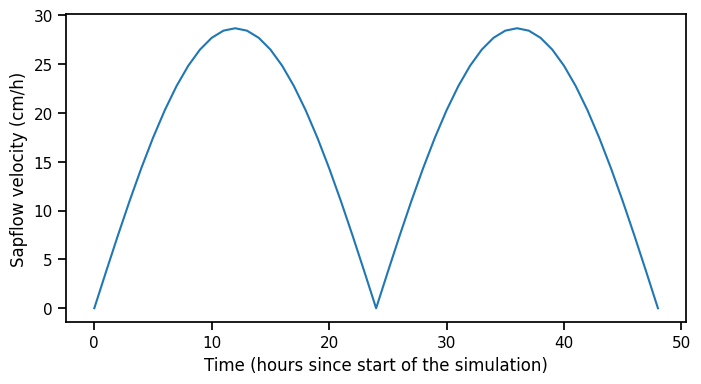

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(simulation_time[:49]/3600, sapflow_velocity[:49]*3600*1e2, linewidth=1.5)

ax.set_xlabel('Time (hours since start of the simulation)')
ax.set_ylabel('Sapflow velocity (cm/h)')

## CH<sub>4</sub> diffusion coefficients

Next we'll set radial and axial diffusion coefficients. We'll assume same value (1.5e-8 m<sup>2</sup>/s) for radial diffusion and set the axial diffusion coefficient to be same as diffusion coefficient of CH<sub>4</sub> in air.

In [22]:
D_ch4_gas_radial = np.repeat([1.5e-8], repeats=na*nr).reshape(na,nr) # m^2/s
D_ch4_gas_axial = np.repeat([2e-5], repeats=na*nr).reshape(na,nr) # m^2/s

## Equilibration rate

The equilibration rate determines the rate at which gas and aquoues phases approach equilibrium given by the Henry's law. Here we set the equilibration rate to high value which leads to fast equilibration.

In [23]:
eq_rate = 0.1 # 1/s

## Space division

Next, we need to set volume fraction of air and aqueous phases and cell in the tree. We'll use same values for each element

In [24]:
w_gas = np.repeat([0.2], na*nr).reshape(na,nr)
w_aq = np.repeat([0.4], na*nr).reshape(na,nr)

w_cell = np.repeat([0.4], na*nr).reshape(na,nr)

space_division = np.stack((w_gas, w_aq, w_cell), axis=2)

## CH<sub>4</sub> uptake through the roots

Next, we need to determine how much CH<sub>4</sub> enters the model via root water uptake (RWU). For this we need to determine first the root water uptake rate in m<sup>3</sup>/s and then the soil aqueous phase CH<sub>4</sub> concentration.

In this example we'll assume that the storage change in the tree is zero in every element i.e., that the RWU rate = Transpiration rate and further, that the transpiration rate equals sapflow density. We'll distribute the RWU rate at different soil depths using an exponential decay function. More precise determination would require calculating RWU explicitly which in turn requires knowledge how roots of the tree are distributed and how much roots the tree has in total.

For soil aqueous phase CH<sub>4</sub> concentration we set a total value of  1 mmol/m<sup>3</sup> (=1 $ \mu $ mol/l) and similar to RWU assume that the concentration decreases exponentially as a function of soil depth.

### Root water uptake rate

In [25]:
# Initialize RWU and soil aqueous phase CH4 concentration arrays.
# The model needs the length of both of these arrays to be the same as the number of axial elements
# but there should be only zeros in elements which are above ground

RWU = np.zeros((na,simulation_time.shape[0]-1)) # Root water uptake rate (m^3/s)


# Define soil depth at the end and middle of each root element (total 5 elements since rooting depth was set to 0.5 m and axial resolution is 10 cm)
z_soil = np.cumsum(element_heights[-5:,0]) # soil layer depth at the end of the layer (m); z_soil = array([0.1, 0.2, 0.3, 0.4, 0.5])

z_middle = np.insert(z_soil, 0, 0.0)
z_middle[:-1] = z_middle[:-1] + np.diff(z_middle)/2.0
z_middle = z_middle[:-1] # soil depth at middle of each layer (m) z_middle = array([0.05, 0.15, 0.25, 0.35, 0.45])

# Define total RWU to be distributed among the 5 root layers
RWU_sum = sapflow_density[1:].reshape(sapflow_density.shape[0]-1, 1) # Total rate of water taken up by the roots in a time step (m^3/s)

RWU_scale = np.exp(-z_middle*10) # % how much of RWU_sum comes from different root layers RWU_scale = array([0.60653066, 0.22313016, 0.082085  , 0.03019738, 0.011109  ])
RWU_scale = RWU_scale/np.sum(RWU_scale) # Normalize to unity RWU_scale = array([0.63640865, 0.23412166, 0.08612854, 0.03168492, 0.01165623])
RWU_scale = RWU_scale.reshape(RWU_scale.shape[0], 1) # reshape for matrix multiplication

RWU[-5:, :] = np.matmul(RWU_scale, RWU_sum.T) # Set RWU rate in the root elements to correct values


### CH<sub>4</sub> concentration in the soil

The difference between CH<sub>4</sub> soil aq concentration array and the RWU array is that in this example we'll keep the soil CH<sub>4</sub> concentration constant in time.

In [26]:
# Initialize ch4 soil concentration array.
# The model needs the length of both of the array to be the same as the number of axial elements
# but there should be only zeros in elements which are above ground (elements 0-99 in this example).
ch4_soil_aq_concentration = np.zeros((na,1))

# Total ch4 concentration in the soil mol/m3
ch4_soil_concentration_total=1e-3

ch4_soil_concentration_scale = np.exp(-z_middle*3)
ch4_soil_concentration_scale = ch4_soil_concentration_scale / np.sum(ch4_soil_concentration_scale)

ch4_soil_aq_concentration[-5:, 0] = ch4_soil_concentration_scale * ch4_soil_concentration_total

### Visualize RWU and CH<sub>4</sub> concentration in the soil

Text(0.5, 1.0, 'Aqueous phase CH$_4$ concentration in soil')

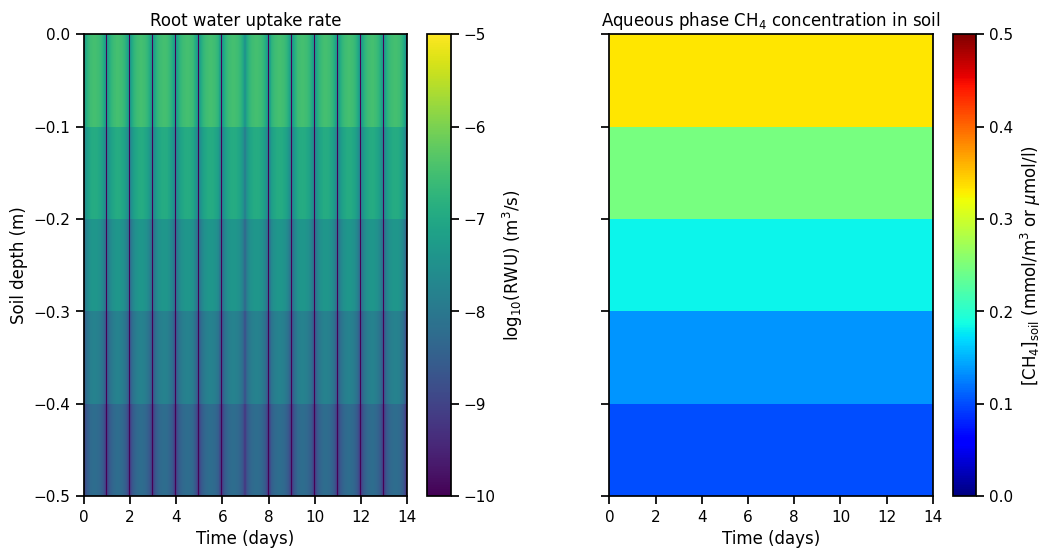

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0.3)

time_in_days = simulation_time/(3600*24)
z_soil_values = np.flip(np.insert(-1.0*z_soil, 0, 0.0))
im = axs[0].pcolormesh(time_in_days, z_soil_values, np.flipud(np.log10(RWU[-5:, :])), vmin=-10, vmax=-5)

cb = fig.colorbar(im, ax=axs[0])
cb.set_label('log$_{10}$(RWU) (m$^3$/s)')

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Soil depth (m)')

axs[0].set_title('Root water uptake rate')

ch4_soil_aq_concentration_values = np.flip(np.transpose((np.tile(ch4_soil_aq_concentration[-5:,0].flatten(), time_in_days.shape[0]-1).reshape(time_in_days.shape[0]-1,5))))

im2 = axs[1].pcolormesh(time_in_days, z_soil_values, ch4_soil_aq_concentration_values*1000, cmap='jet', vmax=0.5, vmin=0)

cb = fig.colorbar(im2, ax=axs[1])

cb.set_label('[CH$_4$]$_{\mathrm{soil}}$ (mmol/m$^3$ or $\mu$mol/l)')

axs[1].set_xlabel('Time (days)')

axs[1].set_title('Aqueous phase CH$_4$ concentration in soil')

## Other sources and sinks

The model allows also definition of other CH<sub>4</sub> sources and sinks. In this example we set one source at ~8 m height and one sink at ~0.1 m height. The source / sink strength is calculated from the current gas phase concentration for every time step

In [28]:
# Define tree height at the middle of the tree. This is needed later.
tree_height_middle = np.cumsum(element_heights[:, 0])
tree_height_middle = np.insert(tree_height_middle, 0, 0.0)
tree_height_middle = tree_height_middle - 0.5 # substract the rooting depth
tree_height_middle[:-1] = tree_height_middle[:-1] + np.diff(tree_height_middle)/2.0
tree_height_middle = tree_height_middle[:-1]
tree_height_middle = np.flip(tree_height_middle) # This flip is required since in the model first index is at the top of the tree

In [29]:
def source_and_sink(current_molar_amount):
    source_and_sink = np.zeros((na, nr, 2)) # the dimensions of the array need to be the same as the current molar amount array's. The each element of the source and sink array needs to be in units mol/s

    # define a source at ca. 8 m height
    ind_8m = np.argmin(np.abs(tree_height_middle-8))

    source_strength = 5e-11 # (mol/s)
    source_and_sink[ind_8m, :, 0] = source_strength

    # define a sink at ca. 0.1 m height

    ind_01m = np.argmin(np.abs(tree_height_middle-0.1))
    
    sink_strength = 1e-4 # (1/s) need to be careful with this value since it applies for one hour before it is updated and can lead to negative concentrations

    source_and_sink[ind_01m, :, 0] = -1.0*current_molar_amount[ind_01m, :, 0] * sink_strength

    return source_and_sink

## Concentration outside the stem

Next we need to set the atmospheric concentration and the concentration in the soil in gas phase. We'll use the value for atmospheric concentration and assume that the soil aqueous and gas phases are in equilibrium.

In [30]:
ambient_concentration = np.repeat([atmospheric_ch4_concentration_mol_m3], repeats=na).reshape(na,1)

# set different value for root lements

ambient_concentration[-5:] = ch4_soil_aq_concentration[-5:]/kh

## Output file and number of lines to save in a timestep

Lastly, we need to set the name of the output file and how many lines we want to save there in each time step. Currently the value of the fluxes can only be saved if number of outputlines per timestep is 1. The results are saved in a NetCDF file.

In [54]:
outputfile = 'ch4_transport_test_out.nc'

output_lines_per_step = 1

# Initialize the model

In [55]:
model = Gas(num_axial_elements=na,
            num_radial_elements=nr,
            element_height=element_heights,
            element_length = element_radius,
            radial_diffusion_coefficient=D_ch4_gas_radial,
            axial_diffusion_coefficient=D_ch4_gas_axial,
            equilibration_rate=eq_rate,
            velocity=sapflow_velocity_whole_tree[:, :, 0],
            space_division=space_division,
            concentration=ch4_concentration,
            henrys_law_coefficient=kh,
            temperature=temperature,
            ambient_concentration= ambient_concentration,
            sources_and_sinks=np.zeros((na,nr,2)),
            soil_compound_aq_concentration=ch4_soil_aq_concentration,
            axial_water_uptake=RWU[:, 0].reshape(na,1),
            outputfile=outputfile,
            max_output_lines=output_lines_per_step
            )

# Run the model

Running the model takes 1-2 minutes

In [56]:
for i, t in enumerate(simulation_time[:-1]):
    if t%86400 == 0:
        print(f'Days elapsed: {t/86400}')
    # update sapflow velocity, source and sink strength and root water uptake rate
    model.velocity = sapflow_velocity_whole_tree[:, :, i]
    model.sources_and_sinks = source_and_sink(model.n_in)
    model.axial_water_uptake = RWU[:, i].reshape(na,1)

    #run for one time step (one hour

    model.run(time_start = t, time_end = simulation_time[i+1])

print('Simulation ready')

Days elapsed: 0.0
Days elapsed: 1.0
Days elapsed: 2.0
Days elapsed: 3.0
Days elapsed: 4.0
Days elapsed: 5.0
Days elapsed: 6.0
Days elapsed: 7.0
Days elapsed: 8.0
Days elapsed: 9.0
Days elapsed: 10.0
Days elapsed: 11.0
Days elapsed: 12.0
Days elapsed: 13.0
Simulation ready


### Close the netcdf output file

In [57]:
model.ncf.close()

# Visualize model output

## Load the simulation output

In [58]:
data = xr.open_dataset('ch4_transport_test_out.nc')

## Define parameters for plotting

In [59]:
tree_height_end = np.flip(np.cumsum(element_heights[:, 0])) - 0.5
tree_height_end = np.insert(tree_height_end, na, -0.5) # height including negative height for the root elements

tree_radius_end = np.cumsum(element_radius[0, :])
tree_radius_end = np.insert(tree_radius_end, 0, 0)*100

plot_time = simulation_time/(24*60*60) # time in days

### Helper function for getting days and hours since simulation start from seconds

In [60]:
def days_and_hours_from_seconds(seconds):
    days = np.floor(seconds/(24*60*60)).astype(np.int32)
    seconds_remaining = seconds%(24*60*60)

    hours = (seconds_remaining / 3600).astype(np.int32)

    return days, hours

## Gas phase concentration at different times

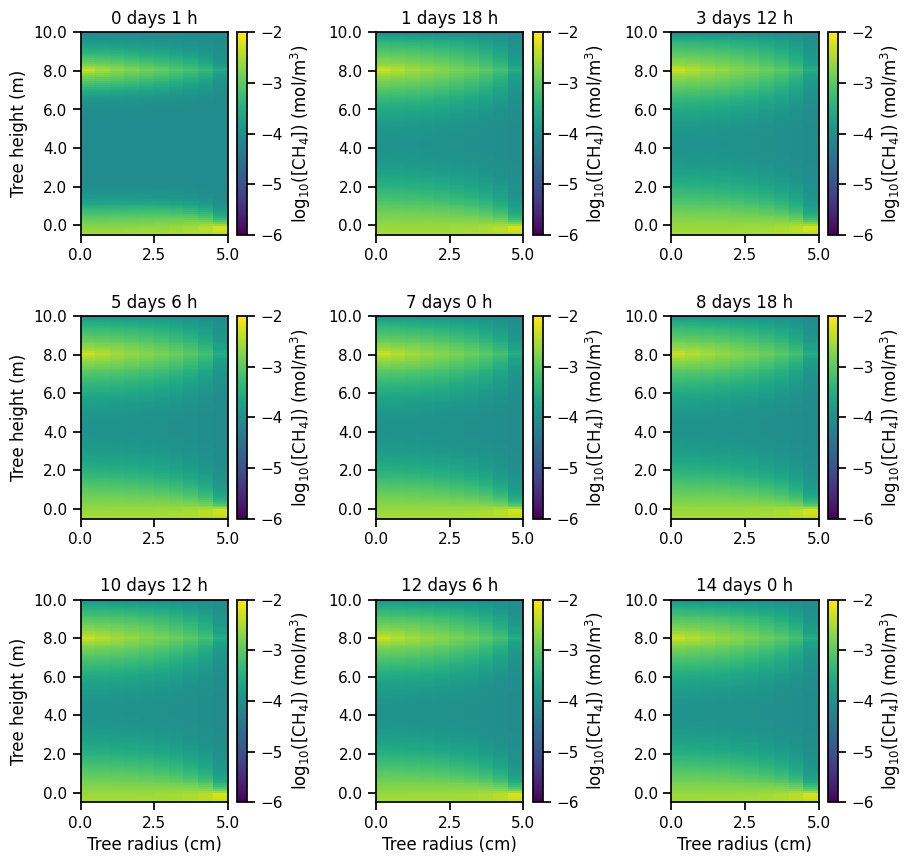

In [61]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

fig.subplots_adjust(wspace=0.6, hspace=0.4)

ind_time = np.linspace(0,simulation_time.shape[0]-2, num=9, dtype=np.int32)

axs = axs.flatten()

yticks = [5, 25, 45, 65, 85, 105]

yticklabels = [f'{i:.1f}' for i in np.flip(tree_height_end)[yticks]]

xticks = [0, 5, 10]

xticklabels = [f'{i:.1f}' for i in tree_radius_end[xticks]]

for i, ax in enumerate(axs):
    im = ax.pcolor(np.flipud(np.log10(data.cmp_concentration[ind_time[i], :, :, 0].values)), vmin=-6, vmax=-2)
    cbar = fig.colorbar(im, ax=ax)

    cbar.set_label('log$_{10}$([CH$_4$]) (mol/m$^3$)')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    days, hours = days_and_hours_from_seconds(simulation_time[ind_time[i]+1])
    ax.set_title(f'{days} days {hours} h')

    if i in [0, 3, 6]:
        ax.set_ylabel('Tree height (m)')

    if i in [6, 7, 8]:
        ax.set_xlabel('Tree radius (cm)')

## Aqueous phase concentration at different times

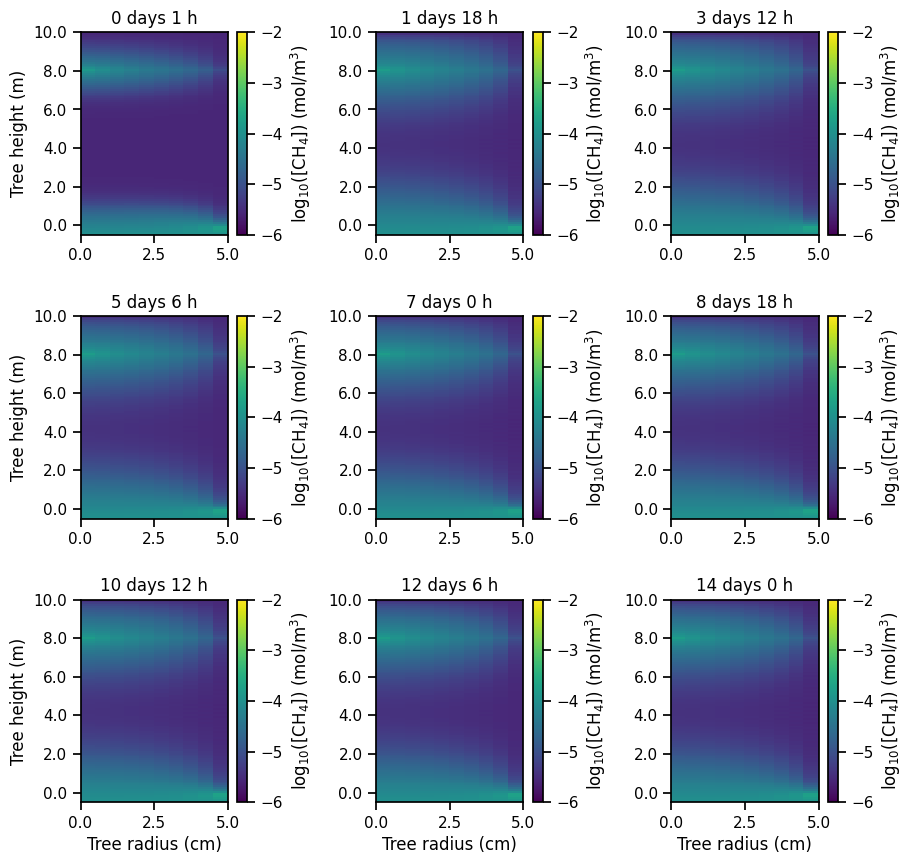

In [62]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

fig.subplots_adjust(wspace=0.6, hspace=0.4)

ind_time = np.linspace(0,simulation_time.shape[0]-2, num=9, dtype=np.int32)

axs = axs.flatten()

yticks = [5, 25, 45, 65, 85, 105]

yticklabels = [f'{i:.1f}' for i in np.flip(tree_height_end)[yticks]]

xticks = [0, 5, 10]

xticklabels = [f'{i:.1f}' for i in tree_radius_end[xticks]]

for i, ax in enumerate(axs):
    im = ax.pcolor(np.flipud(np.log10(data.cmp_concentration[ind_time[i], :, :, 1].values)), vmin=-6, vmax=-2)
    cbar = fig.colorbar(im, ax=ax)

    cbar.set_label('log$_{10}$([CH$_4$]) (mol/m$^3$)')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    days, hours = days_and_hours_from_seconds(simulation_time[ind_time[i]+1])
    ax.set_title(f'{days} days {hours} h')

    if i in [0, 3, 6]:
        ax.set_ylabel('Tree height (m)')

    if i in [6, 7, 8]:
        ax.set_xlabel('Tree radius (cm)')

## CH<sub>4</sub> flux out of the stem

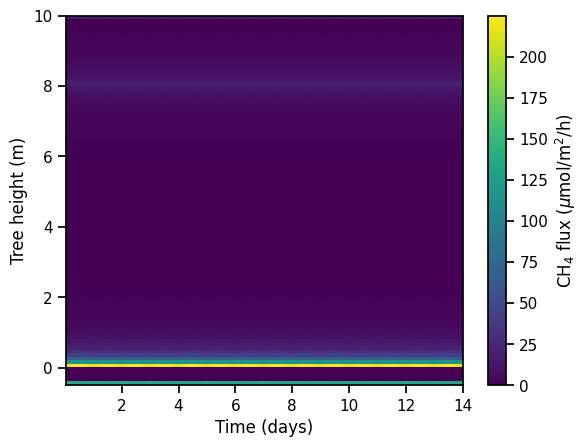

In [63]:
fig, ax = plt.subplots()
n_out = data.cmp_moles_out.values

n_out[n_out < 1e-12] = 1e-12 # set zero values to small values since we take log10 below

flux_out = np.diff(data.cmp_moles_out.values, axis=0)/(basal_area_tree)*1e6 # flux in umol / m2 / h (no need to divide by time since the time step is 1 hour)
im = ax.pcolor(plot_time[1:], tree_height_end, np.transpose(flux_out))
cbar = fig.colorbar(im, ax=ax)
ax.set_ylabel('Tree height (m)')
ax.set_xlabel('Time (days)')
cbar.set_label('CH$_4$ flux ($\mu$mol/m$^2$/h)')

## Plot sapflow velocity and flux at 1 m height

Text(0.5, 0, 'Time (days)')

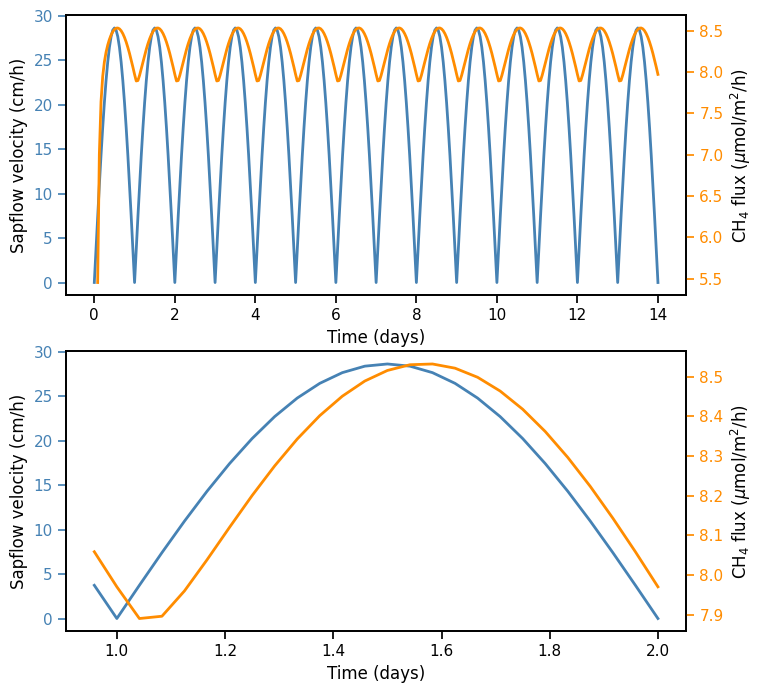

In [64]:
fig, axs = plt.subplots(nrows=2, figsize=(8,8))
ind_1m = np.argmin(np.abs(tree_height_middle-1))
axs[0].plot(simulation_time/(24*60*60), sapflow_velocity*3600*1e2, linewidth=2, color='steelblue')

ax2 = axs[0].twinx()
ax2.plot(simulation_time[2:]/(24*60*60), flux_out[:, ind_1m], color='darkorange', linewidth=2)

axs[0].set_ylabel('Sapflow velocity (cm/h)')
axs[0].tick_params(axis='y', colors='steelblue')

ax2.set_ylabel('CH$_4$ flux ($\mu$mol/m$^2$/h)')
ax2.tick_params(axis='y', colors='darkorange')

axs[0].set_xlabel('Time (days)')



axs[1].plot(simulation_time[23:49]/(24*60*60), sapflow_velocity[23:49]*3600*1e2, linewidth=2, color='steelblue')

ax2 = axs[1].twinx()
ax2.plot(simulation_time[23:49]/(24*60*60), flux_out[21:47, ind_1m], color='darkorange', linewidth=2)

axs[1].set_ylabel('Sapflow velocity (cm/h)')
axs[1].tick_params(axis='y', colors='steelblue')

ax2.set_ylabel('CH$_4$ flux ($\mu$mol/m$^2$/h)')
ax2.tick_params(axis='y', colors='darkorange')

axs[1].set_xlabel('Time (days)')
